# Neural Networks
Neural networks are function estimators that are capable of solving complicated non-linear systems. They can be simply described as a system of multiple linear regression operations enhanced with activation functions in order to increase non-linearity.
<br>
There are 3 components of Neural Networks.
1. Nodes
2. Layers
3. Weights

Nodes are data points which carry a value inside them. Layers are arrays of nodes. In other words, layers are vectors. Each layer is connected to another one with **weights**. Weights are matrix of coefficients. They determine how previous layer  affects the following layer. In the process of neural network training, we try to find the optimum weights that succesfully models the given system.
<br>
Basic neural network can be mathematically represented as below.
<br>
$$f\left(\begin{bmatrix}w_{11}& w_{12}& ...& w_{1n} \\ w_{21}& w_{22}& ...& w_{2n}  \\ ... & ... & ... & ... \\ w_{m1}& w_{m2}& ...& w_{mn}  \end{bmatrix}\begin{bmatrix}x_1 \\ x_2 \\ ... \\ x_n \end{bmatrix}\right)=\begin{bmatrix}z_1 \\ z_2 \\ ... \\ z_m \end{bmatrix}$$
<br>
$$f\left(\begin{bmatrix}w_{11}& w_{12}& ...& w_{1m} \\ w_{21}& w_{22}& ...& w_{2m}  \\ ... & ... & ... & ... \\ w_{i1}& w_{i2}& ...& w_{in}  \end{bmatrix}\begin{bmatrix}z_1 \\ z_2 \\ ... \\ z_m \end{bmatrix}\right)=\begin{bmatrix}y_1 \\ y_2 \\ ... \\ y_i \end{bmatrix}$$
<br>
Where X is the **input layer**, Z is the **hidden layer**, and Y is the **output layer**. There may be many Zs connected to each other depending on the depth of the network.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import numpy as np

In order to accelerate neural network training, we use GPUs.

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


Let's start with creating a dataset.

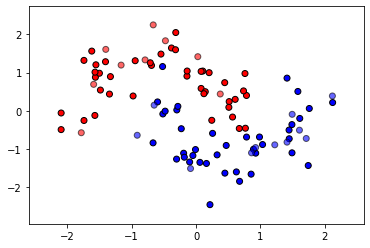

In [3]:
X, y = make_moons(noise=.2, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.transform(X)

# We want to paint the surface of the graph, thus we create a meshgrid.
# We will use these just for determining the canvas size here.
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot()
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
           edgecolors='k')
# Plot the testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
           edgecolors='k')

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())


plt.show()

We will define our neural network, and determine its architecture. In this problem, we will use 2 hidden layers.
<br>
Architecture goes like:
1. 2 dimension imput layer, contributed linearly.
2. 10 dimension hidden layer, used ReLu activation function.
3. 10 dimension hidden layer, used Sigmoid activation function.
4. 2 dimension output layer, used Sigmoid activation function.

While *init* method initializes the model object, forward defines what will happen to an input, and returns corresponding 
output.

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2, 10)
        self.layer2 = nn.Linear(10, 10)
        self.out = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.sigmoid(self.layer2(x))
        return F.sigmoid(self.out(x))

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=1, bias=True)
)


We need to define how loss will be calculated, and which optimization method will be used. <br>
In this example we use **Binary Cross-Entropy Loss** and **Stochastic Gradient Descent**.

In [5]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

## Training

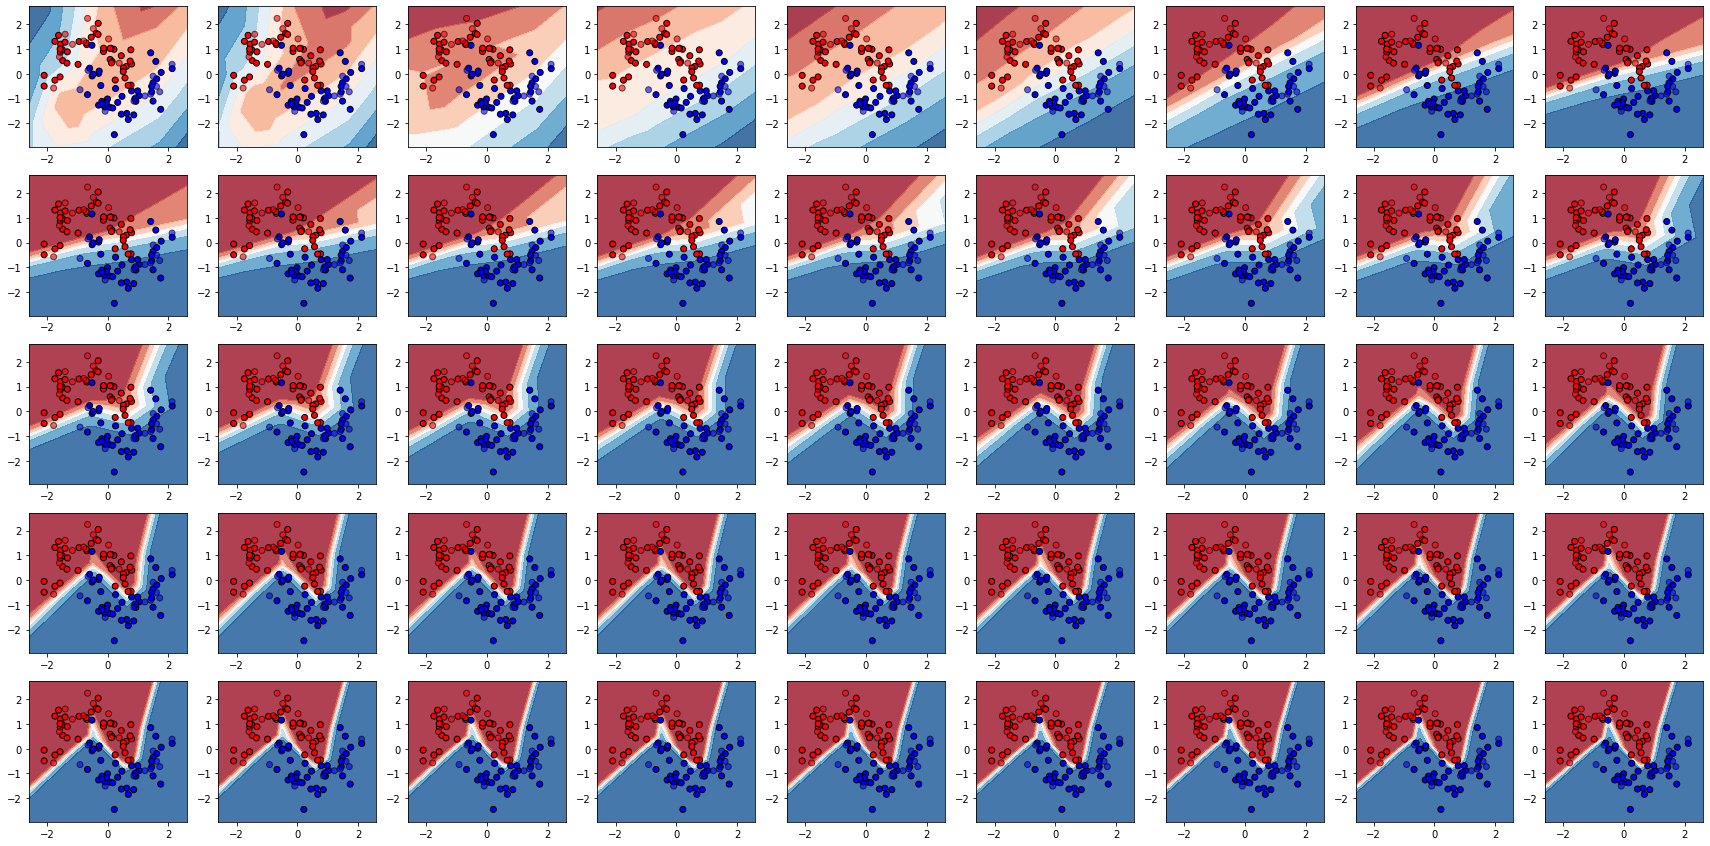

In [6]:
figure = plt.figure(figsize=(30, 15))
ax = plt.subplot(5, 9, 1)
mesh_tensor = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).to(device).float()
X_train_tensor = torch.from_numpy(X_train).to(device).float()
y_train_tensor = torch.from_numpy(y_train).to(device).float()
Z = model(mesh_tensor).cpu().detach().numpy()
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
           edgecolors='k')

ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
           edgecolors='k', alpha=0.6)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())



# We need to iterate over data multiple times, and get a better fit for each step.
# Normally, we use batches instead of full data for calculating the gradients.
# However, as the data is small, we can use full data in order to converge to a
# solution.
for epoch in range(440):
    
    # We start by resetting the calculated gradients.
    optimizer.zero_grad()

    # Then make a prediction.
    outputs = model(X_train_tensor)
    
    # By using that prediction, we calculate the loss.
    loss = criterion(outputs, y_train_tensor.unsqueeze(1))
    
    # We calculate the gradients from that loss function.
    loss.backward()
    
    # We update the weights by using the calculated gradients.
    optimizer.step()

    # We visualize our decision boundaries per 10 epochs.
    if epoch%10==0:
        ax = plt.subplot(5, 9, epoch//10+2)

        Z = model(mesh_tensor).cpu().detach().numpy()

        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')

        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())


plt.show()

As it is obvserved above, we can make a non-linear function estimation using Neural Networks.

## Exercise 1
Adjust neural network so that there will be no activation functions. Observe how this step affects the boundaries. Explain the role of activation layers in a neural network.

*Answer Here*

# MNIST Hand Written Number

In [7]:
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
import time

## Exercise 2
Define various neural network structures with tanh, sigmoid, linear, relu, define number of neurons in each layer and forward the input data to one-hot-coding for numbers 0-9. **You are NOT expected to use Convolution Layers!** <br>
*Hint: Input files are 28x28 images.*
<br>
*Hint: Use .view method in the forward function to make a column vector from 28x28 image *


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        ## Code Here ##
        

        ###############

    def forward(self, img): #convert + flatten
        
        ## Code Here ##
        
        
        ###############
        
        return x


In [9]:
## This function takes a loader, NN model structure, Nth batch selection for either train or test and returns  
## Nth batch data for plotting and debugging


def TakesamplesfromNthBatch(loader,N,model):
    
    inputsout=[]
    labelsout=[]
    
    for i,data in enumerate(train_loader):
        inputs, labels = data
        inputsout=inputs.squeeze().numpy()
        labelsout=labels.numpy()    
           
        if i==N:
            prediction = model(inputs.to(device).view(-1, 784))
            predictionout = np.argmax(prediction.detach().cpu().numpy(),axis=1) 
            break

    return inputsout, labelsout, predictionout


In [10]:
## Normalization and create a tensor for a training/test set 

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [11]:
model=Net().to(device) #Initiate the neural structure coded above.

## Exercise 3
Define a loss function in calculate_loss and optimizer. Try various batch sizes and observe the time passing between each epoch (seeing the whole traing data).

In [12]:
# Define Cost function to assess the training. #hint: CrossEntropyloss function will be ideal. 
calculate_loss = 

# optimizer ADAM, it is basically advance gradient descent to update parameters, define it
optimizer =  

# How many data point will be used for back propagation for each step.
batch_size=

# How many times will the network see the whole training data to update NN structure, parameters
epoch = 

train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size, shuffle=True)

In [13]:
for epoch in range(epoch):
    running_loss = 0.0
    start = time.time() #record run TIME
    
    for i,data in enumerate(train_loader): #In each epoch iterate the training data in the loader
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  #Sets the gradients of all optimized torch.Tensor s to zero.
        output = model(inputs.view(-1, 28*28))
        loss = calculate_loss(output, labels) #calculate a loss for backpropogation
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.5f' %
            (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    end=time.time()
    print("for this epoch time passed:", end-start)
        
print('Finished Training') 

[1,   100] loss: 1.01488
[1,   200] loss: 0.43535
[1,   300] loss: 0.37097
[1,   400] loss: 0.32244
[1,   500] loss: 0.29798
[1,   600] loss: 0.27913
for this epoch time passed: 9.090999841690063
[2,   100] loss: 0.26995
[2,   200] loss: 0.24791
[2,   300] loss: 0.23073
[2,   400] loss: 0.20597
[2,   500] loss: 0.21617
[2,   600] loss: 0.20301
for this epoch time passed: 9.134081840515137
[3,   100] loss: 0.19567
[3,   200] loss: 0.17314
[3,   300] loss: 0.17230
[3,   400] loss: 0.15507
[3,   500] loss: 0.16824
[3,   600] loss: 0.15229
for this epoch time passed: 9.364537000656128
[4,   100] loss: 0.14645
[4,   200] loss: 0.14853
[4,   300] loss: 0.14365
[4,   400] loss: 0.13194
[4,   500] loss: 0.12895
[4,   600] loss: 0.13005
for this epoch time passed: 9.678484916687012
[5,   100] loss: 0.10856
[5,   200] loss: 0.12077
[5,   300] loss: 0.11639
[5,   400] loss: 0.12538
[5,   500] loss: 0.11096
[5,   600] loss: 0.10522
for this epoch time passed: 8.873640775680542
[6,   100] loss: 0.0

In [14]:
correct =0
total=0

#Calculate predictions in test data. Call the model. Take the maximum value in one hot coding for 0-9. 

with torch.no_grad():  #The wrapper with torch.no_grad() temporarily sets all of the requires_grad flags to false
    for data in test_loader:
        inputs, labels = data
        output = model(inputs.to(device).view(-1, 784))
        for idx, i in enumerate(output):
            if torch.argmax(i) == labels[idx]:
                correct +=1
            total +=1
print(f'accuracy: {round(correct/total, 3)}')

accuracy: 0.971


Batch_Size=  100
True Label = 0 
True Label = 4 
True Label = 0 
True Label = 5 
True Label = 2 


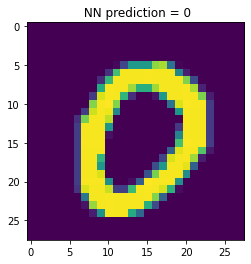

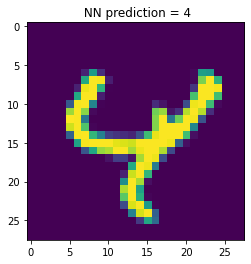

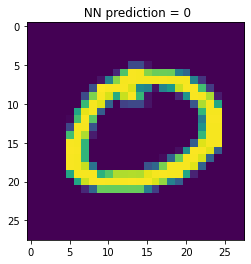

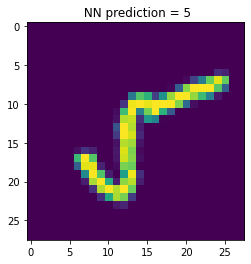

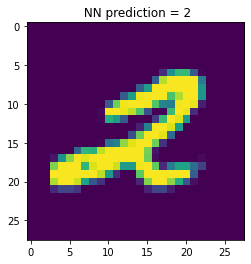

In [15]:
#Get some training or test data samples to visualize the predictions.

trial_input,trial_labels,trial_prediction = TakesamplesfromNthBatch(train_loader,1,model)
print('Batch_Size= ', batch_size)

numberIntheBatch=0 # should be less than batch_size used in loader.
Nofexamples=5
for i in range(Nofexamples):    
    
    plt.figure()
    imgplot = plt.imshow(trial_input[numberIntheBatch])
    plt.title(' NN prediction = %i'  %trial_prediction[numberIntheBatch])
    print('True Label = %i ' %trial_labels[numberIntheBatch])
    numberIntheBatch=numberIntheBatch+1 # should be less than batch_size used in loader.

## Exercise 4
Save loss for each epoch for training and test data and plot Loss vs Epoch

## Feedback
If you have any questions or suggestions you can use this area.